# Classification using Word2Vec

## Imports

In [12]:
!pip install transformers datasets

In [13]:
import math
from copy import deepcopy

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
from matplotlib import pyplot as plt
from tabulate import tabulate
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from transformers import BertTokenizer

## Data preparation

In [14]:
dataset = load_dataset("scikit-learn/imdb", split="train")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

VOCSIZE = len(tokenizer.vocab)
print("Length of the vocabulary:", VOCSIZE)

Length of the vocabulary: 30522


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [15]:
def preprocessing_fn(x, tokenizer):
    x["review_ids"] = tokenizer(
        x["review"],
        add_special_tokens=False,
        truncation=True,
        max_length=256,
        padding=False,
        return_attention_mask=False,
    )["input_ids"]
    x["label"] = 0 if x["sentiment"] == "negative" else 1
    return x

n_samples = 5000  # the number of training example

# We first shuffle the data !
dataset = dataset.shuffle()

# Select 5000 samples
splitted_dataset = dataset.select(range(n_samples))

# Tokenize the dataset
splitted_dataset = splitted_dataset.map(
    preprocessing_fn, fn_kwargs={"tokenizer": tokenizer}
)


# Remove useless columns
splitted_dataset = splitted_dataset.select_columns(["review_ids", "label"])

# Split the train and validation
splitted_dataset = splitted_dataset.train_test_split(test_size=0.2)

train_set = splitted_dataset["train"]
valid_set = splitted_dataset["test"]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [16]:
class DataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        # `batch` is a list of dictionary with keys "review_ids" and "label".
        features = [{"input_ids": x["review_ids"]} for x in batch]
        features = self.tokenizer.pad(
            features, padding="max_length", max_length=256, return_tensors="pt"
        )
        label = torch.tensor([x["label"] for x in batch])[:, None]
        return {"review_ids": features["input_ids"], "label": label}

data_collator = DataCollator(tokenizer)

In [17]:
batch_size = 32

train_dataloader = DataLoader(
    train_set, batch_size=batch_size, collate_fn=data_collator
)
valid_dataloader = DataLoader(
    valid_set, batch_size=batch_size, collate_fn=data_collator
)
n_valid = len(valid_set)
n_train = len(train_set)

## Model

In [18]:
class Conv1dClassifier(nn.Module):
    """A text classifier:
    - input = minibatch
    - output = probability associated to a binary classification task
    - vocab_size: the number of words in the vocabulary we want to embed
    - embedding_dim: size of the word vectors
    """

    def __init__(self, vocab_size: int, embeddings: nn.Embedding, feature_size: int = 100, kernel_size: int = 3):
        super().__init__()
        self.feature_size = feature_size
        self.embeddings = embeddings
        self.embedding_dim = self.embeddings.embedding_dim

        self.conv = nn.Conv1d(
            self.embedding_dim,
            feature_size,
            kernel_size,
            padding=math.floor(kernel_size / 2),
        )

        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(feature_size, 1)
        self.out_activation = nn.Sigmoid()

    def forward(self, input_ids: torch.Tensor):
        # In pytorch, convolution expects (B,d,L)
        # B: the batch dimension
        # d: the embedding dimension
        # L: the length of the sequence
        hidden_states = self.embeddings(input_ids).permute(0, 2, 1)
        hidden_states = F.relu(self.conv(hidden_states))
        hidden_states = self.pool(hidden_states)  # --> (B,d,1)
        # Before the linear, do something with dims the dimension
        # Because Linear works on the final dim
        # (B,d,1) -> (B,d)
        hidden_states = hidden_states.squeeze(dim=2)
        hidden_states = self.dropout(hidden_states)
        logits = self.linear(hidden_states)
        return self.out_activation(logits)

In [19]:
device = torch.device('cpu')

def load_model(path: str, *, freeze: bool = False):
  torch.serialization.add_safe_globals([nn.Embedding, set])
  embeddings = torch.load(path, map_location=device, weights_only=True)

  if freeze:
    embeddings.weight.requires_grad = False

  return Conv1dClassifier(
    vocab_size=VOCSIZE,
    embeddings=embeddings,
  )

def create_default_model(embedding_dim: int, *, freeze: bool = False):
  embeddings = nn.Embedding(VOCSIZE, embedding_dim)

  if freeze:
    embeddings.weight.requires_grad = False

  return Conv1dClassifier(
    vocab_size=VOCSIZE,
    embeddings=embeddings,
  )


model_default = create_default_model(50)
model_pretrained = load_model('model_dim-50_radius-3_ratio-5-batch-1200-epoch-10.ckpt')


# Test on random sentence

random_inputs = torch.randint(0, VOCSIZE, (4, 100))

with torch.no_grad():
  print(torch.stack([
    model_default(random_inputs),
    model_pretrained(random_inputs),
  ]).squeeze().T)

tensor([[0.3647, 0.3054],
        [0.5198, 0.6775],
        [0.5882, 0.4778],
        [0.5252, 0.4777]])


## Training

In [20]:
def train_model(model: nn.Module):
  loss_function = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  n_epochs = 10
  train_losses = []
  valid_losses = []
  train_accs = []
  valid_accs = []

  model.to(device)


  def compute_accuracy(predictions, labels):
      pred = (predictions > 0.5).int()
      correct = (labels == pred).sum().item()
      return correct


  def train_one_epoch(model, dataloader, optimizer, loss_function):
      model.train()
      total_loss = 0
      correct = 0
      total_batches = len(dataloader)

      for batch in tqdm(dataloader, leave=True):
          batch = {k: v.to(device) for k, v in batch.items()}
          optimizer.zero_grad()
          probs = model(batch["review_ids"])
          gold = batch["label"]

          correct += compute_accuracy(probs, gold)
          loss = loss_function(probs, gold.float())
          loss.backward()
          optimizer.step()
          total_loss += loss.item()

      avg_loss = total_loss / total_batches
      avg_accuracy = (correct * 100) / n_train  # Calculate accuracy in percentage
      return avg_loss, avg_accuracy


  def validate_one_epoch(model, dataloader, loss_function):
      model.eval()
      total_loss = 0
      correct = 0
      total_batches = len(dataloader)

      with torch.no_grad():
          for batch in tqdm(dataloader, leave=True):
              batch = {k: v.to(device) for k, v in batch.items()}
              probs = model(batch["review_ids"])
              gold = batch["label"]

              correct += compute_accuracy(probs, gold)
              loss = loss_function(probs, gold.float())
              total_loss += loss.item()

      avg_loss = total_loss / total_batches
      avg_accuracy = (correct * 100) / n_valid  # Calculate accuracy in percentage
      return avg_loss, avg_accuracy


  for epoch in range(n_epochs):
      train_avg_loss, train_avg_acc = train_one_epoch(
          model, train_dataloader, optimizer, loss_function
      )
      valid_avg_loss, valid_avg_acc = validate_one_epoch(
          model, valid_dataloader, loss_function
      )

      train_losses.append(train_avg_loss)
      valid_losses.append(valid_avg_loss)
      train_accs.append(train_avg_acc)
      valid_accs.append(valid_avg_acc)

      print(
          f"Epoch {epoch+1}/{n_epochs}",
          f"Train Loss: {train_avg_loss:.2f}",
          f"Train Acc: {train_avg_acc:.2f}%",
          f" | Valid Loss: {valid_avg_loss:.2f}",
          f"Valid Acc: {valid_avg_acc:.2f}%",
      )

  return valid_accs

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/10 Train Loss: 0.73 Train Acc: 51.80%  | Valid Loss: 0.67 Valid Acc: 61.20%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/10 Train Loss: 0.66 Train Acc: 59.77%  | Valid Loss: 0.63 Valid Acc: 68.80%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/10 Train Loss: 0.60 Train Acc: 68.22%  | Valid Loss: 0.58 Valid Acc: 71.00%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/10 Train Loss: 0.56 Train Acc: 71.97%  | Valid Loss: 0.56 Valid Acc: 72.30%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/10 Train Loss: 0.52 Train Acc: 74.45%  | Valid Loss: 0.53 Valid Acc: 74.50%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/10 Train Loss: 0.48 Train Acc: 77.95%  | Valid Loss: 0.51 Valid Acc: 76.30%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/10 Train Loss: 0.44 Train Acc: 80.03%  | Valid Loss: 0.49 Valid Acc: 76.40%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/10 Train Loss: 0.41 Train Acc: 81.70%  | Valid Loss: 0.48 Valid Acc: 76.90%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/10 Train Loss: 0.39 Train Acc: 82.83%  | Valid Loss: 0.47 Valid Acc: 78.00%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/10 Train Loss: 0.36 Train Acc: 85.00%  | Valid Loss: 0.46 Valid Acc: 78.40%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/10 Train Loss: 0.72 Train Acc: 52.85%  | Valid Loss: 0.67 Valid Acc: 58.70%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/10 Train Loss: 0.66 Train Acc: 59.65%  | Valid Loss: 0.63 Valid Acc: 68.50%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/10 Train Loss: 0.62 Train Acc: 64.90%  | Valid Loss: 0.60 Valid Acc: 70.20%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/10 Train Loss: 0.59 Train Acc: 69.33%  | Valid Loss: 0.57 Valid Acc: 71.00%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/10 Train Loss: 0.56 Train Acc: 70.62%  | Valid Loss: 0.56 Valid Acc: 71.10%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/10 Train Loss: 0.53 Train Acc: 74.00%  | Valid Loss: 0.54 Valid Acc: 73.00%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/10 Train Loss: 0.52 Train Acc: 74.45%  | Valid Loss: 0.54 Valid Acc: 72.50%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/10 Train Loss: 0.51 Train Acc: 74.72%  | Valid Loss: 0.53 Valid Acc: 73.80%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/10 Train Loss: 0.49 Train Acc: 77.12%  | Valid Loss: 0.52 Valid Acc: 75.60%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/10 Train Loss: 0.49 Train Acc: 76.38%  | Valid Loss: 0.51 Valid Acc: 74.50%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/10 Train Loss: 0.70 Train Acc: 51.92%  | Valid Loss: 0.69 Valid Acc: 54.90%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/10 Train Loss: 0.67 Train Acc: 59.27%  | Valid Loss: 0.68 Valid Acc: 57.00%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/10 Train Loss: 0.64 Train Acc: 66.85%  | Valid Loss: 0.68 Valid Acc: 59.20%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/10 Train Loss: 0.58 Train Acc: 74.22%  | Valid Loss: 0.67 Valid Acc: 59.90%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/10 Train Loss: 0.49 Train Acc: 81.92%  | Valid Loss: 0.65 Valid Acc: 62.70%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/10 Train Loss: 0.39 Train Acc: 87.67%  | Valid Loss: 0.65 Valid Acc: 62.60%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/10 Train Loss: 0.29 Train Acc: 93.08%  | Valid Loss: 0.65 Valid Acc: 63.20%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/10 Train Loss: 0.20 Train Acc: 95.83%  | Valid Loss: 0.66 Valid Acc: 64.50%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/10 Train Loss: 0.14 Train Acc: 97.72%  | Valid Loss: 0.68 Valid Acc: 64.50%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/10 Train Loss: 0.10 Train Acc: 98.25%  | Valid Loss: 0.72 Valid Acc: 64.90%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/10 Train Loss: 0.71 Train Acc: 49.75%  | Valid Loss: 0.69 Valid Acc: 53.50%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/10 Train Loss: 0.68 Train Acc: 57.35%  | Valid Loss: 0.68 Valid Acc: 57.70%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/10 Train Loss: 0.66 Train Acc: 61.95%  | Valid Loss: 0.68 Valid Acc: 56.90%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/10 Train Loss: 0.64 Train Acc: 64.95%  | Valid Loss: 0.69 Valid Acc: 54.40%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/10 Train Loss: 0.61 Train Acc: 68.38%  | Valid Loss: 0.69 Valid Acc: 54.90%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/10 Train Loss: 0.58 Train Acc: 71.40%  | Valid Loss: 0.68 Valid Acc: 55.20%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/10 Train Loss: 0.55 Train Acc: 75.15%  | Valid Loss: 0.69 Valid Acc: 56.10%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/10 Train Loss: 0.51 Train Acc: 78.60%  | Valid Loss: 0.68 Valid Acc: 57.70%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/10 Train Loss: 0.48 Train Acc: 80.62%  | Valid Loss: 0.69 Valid Acc: 58.50%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/10 Train Loss: 0.44 Train Acc: 82.78%  | Valid Loss: 0.69 Valid Acc: 58.10%


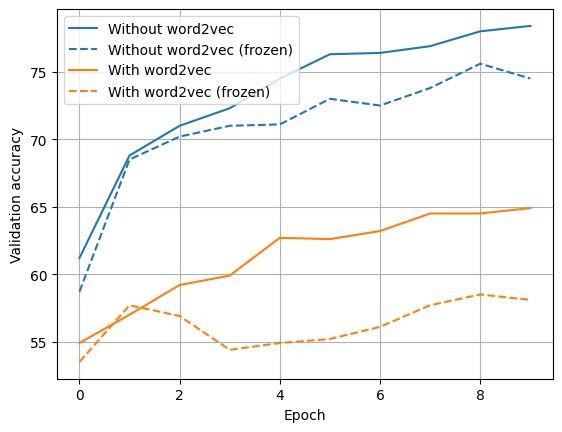

In [21]:
fig, ax = plt.subplots()

model_default = create_default_model(50)
model_random = deepcopy(model_default)
model_random.embeddings.weight.requires_grad = False # Freeze with the same initial weights

for model, kwargs in zip(
  [
    model_default,
    model_random,
    load_model('model_dim-50_radius-3_ratio-5-batch-1200-epoch-10.ckpt'),
    load_model('model_dim-50_radius-3_ratio-5-batch-1200-epoch-10.ckpt', freeze=True),
  ],
  [
    dict(color='C0', linestyle='-', label='Without word2vec'),
    dict(color='C0', linestyle='--', label='Without word2vec (frozen)'),
    dict(color='C1', linestyle='-', label='With word2vec'),
    dict(color='C1', linestyle='--', label='With word2vec (frozen)'),
  ],
):
  val_accuracy = train_model(model)
  ax.plot(val_accuracy, **kwargs) # type: ignore

ax.set_xlabel('Epoch')
ax.set_ylabel('Validation accuracy')
ax.grid()
ax.legend(loc='upper left')
plt.show()

In [22]:
# For testing different values of K and R

if False:
  models = [
    load_model('model_dim-50_radius-3_ratio-5-batch-1200-epoch-10.ckpt', freeze=True),
    load_model('model_dim-50_radius-3_ratio-10-batch-1200-epoch-10.ckpt', freeze=True),
    load_model('model_dim-50_radius-6_ratio-5-batch-1200-epoch-10.ckpt', freeze=True),
    load_model('model_dim-50_radius-6_ratio-10-batch-1200-epoch-10.ckpt', freeze=True),
  ]

  replicate_count = 5
  results = torch.empty((len(models), replicate_count))

  for replicate_index in range(replicate_count):
    for model_index, model in enumerate(models):
      results[model_index, replicate_index] = train_model(model)[-1]

  print(results.mean(dim=1))